In [7]:
from pathlib import Path

import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import probplot

# Import models
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ARDRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, ConstantKernel, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import cross_val_score, RepeatedKFold, permutation_test_score, LeaveOneGroupOut
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

from yellowbrick.regressor import PredictionError

from analyze_snar.statistics import bbc_cv_correction
from analyze_snar.statistics import score_r2, score_mae, score_mse
from analyze_snar.evaluation_tools import EstFamily, extract_family_results, score_estimator_family, ScoringFunction

Plotting options

In [8]:
plt.style.use("default")
%matplotlib inline
%config InlineBackend.figure_format = "png"
figsize_default = np.array(matplotlib.rc_params()["figure.figsize"])

### Load training data

In [9]:
train = np.load("train_test_data/train_indices.npy")
test = np.load("train_test_data/test_indices.npy")

In [10]:
X = pd.read_csv("train_test_data/X.csv", index_col=0).loc[train]
X_s = pd.read_csv("train_test_data/X_s.csv", index_col=0).loc[train]
X_ts = pd.read_csv("train_test_data/X_ts.csv", index_col=0).loc[train]
X_no_ts = pd.read_csv("train_test_data/X_no_ts.csv", index_col=0).loc[train]
X_surf = pd.read_csv("train_test_data/X_surf.csv", index_col=0).loc[train]
X_trad = pd.read_csv("train_test_data/X_trad.csv", index_col=0).loc[train]
X_ohe = pd.read_csv("train_test_data/X_ohe.csv", index_col=0).loc[train]
X_morgan_1 = pd.read_csv("train_test_data/X_morgan_1.csv", index_col=0).loc[train]
X_morgan_2 = pd.read_csv("train_test_data/X_morgan_2.csv", index_col=0).loc[train]
X_morgan_3 = pd.read_csv("train_test_data/X_morgan_3.csv", index_col=0).loc[train]
X_morgan_3_bit = pd.read_csv("train_test_data/X_morgan_3_bit.csv", index_col=0).loc[train]
X_morgan_3_512 = pd.read_csv("train_test_data/X_morgan_3_512.csv", index_col=0).loc[train]
X_morgan_3_2048 = pd.read_csv("train_test_data/X_morgan_3_2048.csv", index_col=0).loc[train]
X_morgan_4 = pd.read_csv("train_test_data/X_morgan_4.csv", index_col=0).loc[train]
X_morgan_5 = pd.read_csv("train_test_data/X_morgan_5.csv", index_col=0).loc[train]
X_morgan_6 = pd.read_csv("train_test_data/X_morgan_6.csv", index_col=0).loc[train]
X_bert_ft = pd.read_csv("train_test_data/X_bert_ft.csv", index_col=0).loc[train]
X_bert_pt = pd.read_csv("train_test_data/X_bert_pt.csv", index_col=0).loc[train]
X_isida_seq_6 = pd.read_csv("train_test_data/X_isida_seq_6.csv", index_col=0).loc[train]
X_isida_seq_8 = pd.read_csv("train_test_data/X_isida_seq_8.csv", index_col=0).loc[train]
X_isida_atom_4 = pd.read_csv("train_test_data/X_isida_atom_4.csv", index_col=0).loc[train]
X_isida_atom_8 = pd.read_csv("train_test_data/X_isida_atom_8.csv", index_col=0).loc[train]
activation_energies = pd.read_csv("train_test_data/activation_energies.csv", index_col=0).loc[train]
y = pd.read_csv("train_test_data/y.csv", index_col=0).loc[train].values.reshape(-1)

In [11]:
X_poc_morgan_3 = pd.concat([X_morgan_3.iloc[:,:-5], X], axis=1)
X_poc_bert = pd.concat([X_bert_pt.iloc[:,:-5], X], axis=1)

In [12]:
X.shape

(354, 33)

### Select DFT energy

ts


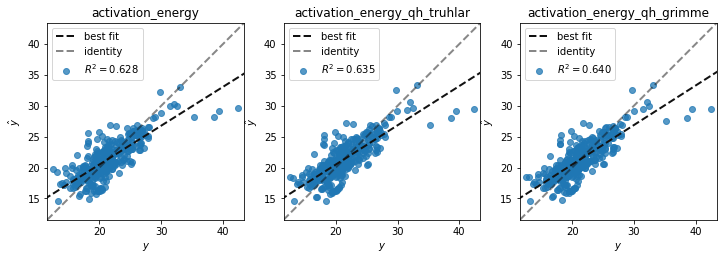

nu


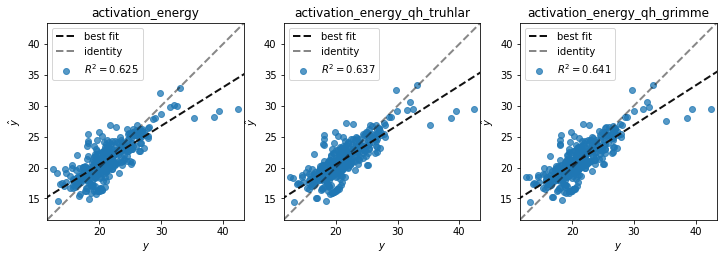

none


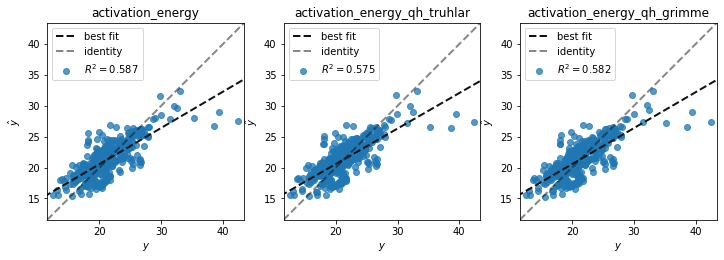

In [13]:
results = {"type": [], "raw_rmse": [], "raw_mae": [], "raw_r2": [], "linear_rmse": [], "linear_mae": [], "linear_r2": [], "clustering": []}
for label in ("ts", "nu", "none"):
    print(label)
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    for i, energy in enumerate(["activation_energy", "activation_energy_qh_truhlar", "activation_energy_qh_grimme"]):
        x_, y_ = activation_energies[f"{energy}_{label}"].values.reshape(-1, 1), y
        visualizer = PredictionError(LinearRegression(), ax=ax[i])
        visualizer.fit(x_, y_)
        visualizer.score(x_, y_)
        visualizer.finalize()
        ax[i].title.set_text(energy)
        results["type"].append(energy)
        results["raw_rmse"].append(np.sqrt(mean_squared_error(y_, x_)))
        results["raw_mae"].append(mean_absolute_error(y_, x_))
        results["raw_r2"].append(r2_score(y_, x_))
        preds = LinearRegression().fit(x_, y_).predict(x_)
        results["linear_rmse"].append(np.sqrt(mean_squared_error(y_, preds)))
        results["linear_mae"].append(mean_absolute_error(y_, preds))
        results["linear_r2"].append(r2_score(y_, preds))    
        results["clustering"].append(label)
    plt.show()

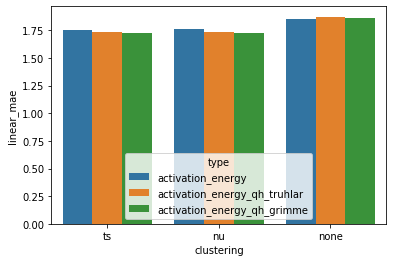

In [14]:
results_df = pd.DataFrame(results)
sns.barplot(x="clustering", y="linear_mae", hue="type", data=results_df)

In [15]:
results_df

,type,raw_rmse,raw_mae,raw_r2,linear_rmse,linear_mae,linear_r2,clustering
0,activation_energy,4.073134,3.257069,-0.084453,2.384091,1.749729,0.628466,ts
1,activation_energy_qh_truhlar,3.728330,2.921090,0.091381,2.361652,1.737643,0.635427,ts
2,activation_energy_qh_grimme,3.734698,2.928871,0.088274,2.346714,1.728468,0.640024,ts
3,activation_energy,4.059691,3.228928,-0.077306,2.396331,1.764356,0.624641,nu
4,activation_energy_qh_truhlar,3.699697,2.882129,0.105283,2.357561,1.733230,0.636689,nu
5,activation_energy_qh_grimme,3.708106,2.889768,0.101211,2.344192,1.725698,0.640797,nu
6,activation_energy,4.803391,3.839135,-0.508166,2.514590,1.852413,0.586679,none
7,activation_energy_qh_truhlar,4.436817,3.443227,-0.286757,2.550025,1.872482,0.574948,none
8,activation_energy_qh_grimme,4.428655,3.446246,-0.282027,2.527791,1.863447,0.582328,none


Proceed with qh_grimme and full clustering (TS + nu) as well as no clustering for comparison

In [16]:
activation_energy = activation_energies["activation_energy_qh_grimme_ts"]

In [17]:
X["activation_energy"] = activation_energy
X_s["activation_energy"] = activation_energy
X_ts["activation_energy"] = activation_energy

DFT activation energy

In [18]:
X_dft = X[["activation_energy"]]

### Investigate features

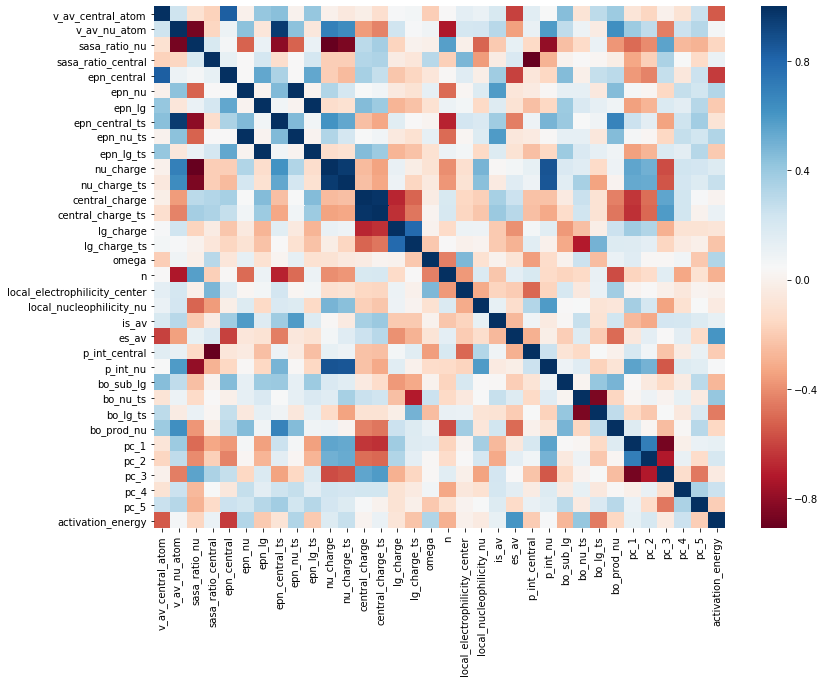

In [19]:
fig, ax = plt.subplots(figsize=figsize_default * [2, 2])
sns.heatmap(X.corr(), cmap="RdBu")

In [20]:
vifs = pd.Series(np.linalg.inv(X.corr("pearson")).diagonal(), index=X.columns, name="VIF")

Text(0.5, 0, 'Feature')

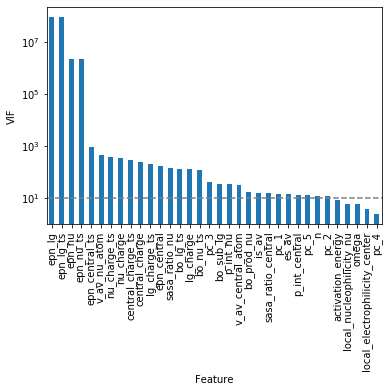

In [21]:
vifs.sort_values(ascending=False).plot.bar()
plt.yscale("log")
plt.axhline(10, linestyle="--", color="gray")
plt.ylabel("VIF")
plt.xlabel("Feature")

### Simple checks with linear model

Residuals with train test split 

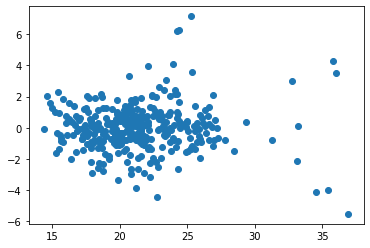

In [22]:
lr = LinearRegression()
lr.fit(X, y)
preds = lr.predict(X)
residuals = preds - y
plt.scatter(preds, residuals)

qq plot

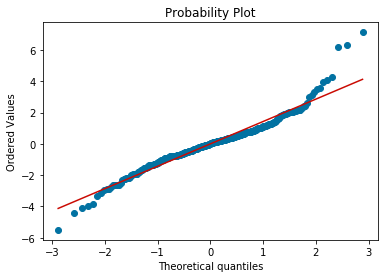

In [23]:
_ = probplot(residuals, plot=plt)

### Set up models

GPR

In [24]:
kernel = ConstantKernel() * Matern(nu=1.5) + WhiteKernel()
est = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_matern_3_2 = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

In [25]:
kernel = ConstantKernel() * Matern(nu=1.5) + WhiteKernel()
ct = ColumnTransformer([("columntransformer", StandardScaler(), slice(-5, None))], remainder="passthrough")
est = make_pipeline(ct, GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_matern_3_2_cat = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

In [26]:
kernel = ConstantKernel() * Matern(nu=1.5) + WhiteKernel()
ct = ColumnTransformer([("columntransformer", StandardScaler(), slice(-34, None))], remainder="passthrough")
est = make_pipeline(ct, GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_matern_3_2_cat_34 = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

In [27]:
kernel = ConstantKernel() * Matern(nu=2.5) + WhiteKernel()
est = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_matern_5_2 = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

In [28]:
kernel = ConstantKernel() * RBF() + WhiteKernel()
est = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_rbf = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

In [29]:
kernel = ConstantKernel() * RationalQuadratic() + WhiteKernel()
est = make_pipeline(StandardScaler(), GaussianProcessRegressor(kernel=kernel, random_state=1))
est_gpr_rq = TransformedTargetRegressor(regressor=est, transformer=StandardScaler())

### Modelling

Set up CV folds

In [30]:
n_folds = 10
n_repeats = 1
cv_folds = list(RepeatedKFold(n_folds, n_repeats, random_state=1).split(y))

Set up scoring functions

In [31]:
scoring_functions = [ScoringFunction("r2", score_r2, True),
                     ScoringFunction("mae", score_mae, False), 
                     ScoringFunction("rmse", lambda x, y: score_mse(x, y, squared=False), False),
                    ]

Set up families of estimators to test 

In [32]:
est_families_path = Path("est_families.joblib")
if est_families_path.is_file():
    with open(est_families_path, "rb") as file:
        est_families = joblib.load(file)
else:
    est_families = []

family_results_path = Path("family_results.joblib")
if family_results_path.is_file():
    with open(family_results_path, "rb") as file:
        family_results = joblib.load(file)
else:
    family_results = {scoring_function.name: {} for scoring_function in scoring_functions}

In [33]:
est_families_additions = [
    # Base line models
    EstFamily("DFT LR", LinearRegression(), X_dft, None),
    EstFamily("DFT GPR M 1.5", clone(est_gpr_matern_3_2), X_dft, None),
    EstFamily("DFT LR FI", LinearRegression(fit_intercept=False), X_dft, None),
    EstFamily("Mean", DummyRegressor(strategy="mean"), X, None),
    EstFamily("Median", DummyRegressor(strategy="median"), X, None),
    
    # Main methods for full descriptor set
    EstFamily("LR", LinearRegression(), X, None),
    EstFamily("KNN", KNeighborsRegressor(), X, {"n_neighbors": np.arange(1, 19, 3)}),
    EstFamily("KNN PF", make_pipeline(PolynomialFeatures(2), KNeighborsRegressor()), X, {"kneighborsregressor__n_neighbors": np.arange(1, 19, 3)}),
    EstFamily("LR PF", make_pipeline(PolynomialFeatures(2), LinearRegression()), X, None),
    EstFamily("BR", BayesianRidge(), X, None),
    EstFamily("BR PF", make_pipeline(PolynomialFeatures(2), BayesianRidge()), X, None),
    EstFamily("ARD", ARDRegression(), X, None),
    EstFamily("ARD PF", make_pipeline(PolynomialFeatures(2), ARDRegression()), X, None),
    EstFamily("PLS", PLSRegression(), X, {"n_components": np.arange(1, 15)}),
    EstFamily("PLS PF", make_pipeline(PolynomialFeatures(2), PLSRegression()), X, {"plsregression__n_components": np.arange(1, 15)}),
    EstFamily("GPR RBF", clone(est_gpr_rbf), X, None),
    EstFamily("GPR M 1.5", clone(est_gpr_matern_3_2), X, None),
    EstFamily("GPR M 2.5", clone(est_gpr_matern_5_2), X, None),
    EstFamily("GPR RQ", clone(est_gpr_rq), X, None),    
    EstFamily("RF", RandomForestRegressor(random_state=1), X, {"n_estimators": [10, 20, 100, 200], "max_depth": [5, 10, 15, 20, None]}),
    EstFamily("GB", GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=10, random_state=1), X, {"learning_rate": [0.001, 0.01, 0.1], "max_depth": [1, 2, 3, 4, 5]}),
    EstFamily("SVR", make_pipeline(StandardScaler(), SVR()), X, {"svr__C": np.logspace(-3, 3, 10) , "svr__gamma": np.logspace(-3, 3, 10)}),
    
    # Different datasets: Full, no TS, only TS, Surface, Traditional
    EstFamily("GPR M 1.5 S", clone(est_gpr_matern_3_2), X_s, None),
    EstFamily("GPR M 1.5 no TS", clone(est_gpr_matern_3_2), X_no_ts, None),
    EstFamily("GPR M 1.5 TS", clone(est_gpr_matern_3_2), X_ts, None),
    EstFamily("GPR M 1.5 Surf", clone(est_gpr_matern_3_2), X_surf, None),
    EstFamily("GPR M 1.5 Trad", clone(est_gpr_matern_3_2), X_trad, None),
    EstFamily("GPR M 1.5 POC Morgan3", clone(est_gpr_matern_3_2_cat_34), X_poc_morgan_3, None),
    EstFamily("GPR M 1.5 POC BERT", clone(est_gpr_matern_3_2_cat_34), X_poc_bert, None),
    EstFamily("RF GS POC Morgan3", RandomForestRegressor(random_state=1), X_poc_morgan_3, {"n_estimators": [10, 20, 100, 200], "max_depth": [5, 10, 15, 20, None]}),
    
    # Baseline comparisons OHE, RFPs, ISIDA
    EstFamily("GPR M 1.5 OHE", clone(est_gpr_matern_3_2_cat), X_ohe, None),
    EstFamily("GPR M 1.5 Morgan1", clone(est_gpr_matern_3_2_cat), X_morgan_1, None),
    EstFamily("GPR M 1.5 Morgan2", clone(est_gpr_matern_3_2_cat), X_morgan_2, None),
    EstFamily("GPR M 1.5 Morgan3", clone(est_gpr_matern_3_2_cat), X_morgan_3, None),
    EstFamily("GPR M 1.5 Morgan3 bit", clone(est_gpr_matern_3_2_cat), X_morgan_3_bit, None),
    EstFamily("GPR M 1.5 Morgan3 512", clone(est_gpr_matern_3_2_cat), X_morgan_3_512, None),
    EstFamily("GPR M 1.5 Morgan3 2048", clone(est_gpr_matern_3_2_cat), X_morgan_3_2048, None),
    EstFamily("GPR M 1.5 Morgan4", clone(est_gpr_matern_3_2_cat), X_morgan_4, None),
    EstFamily("GPR M 1.5 Morgen5", clone(est_gpr_matern_3_2_cat), X_morgan_5, None),
    EstFamily("GPR M 1.5 Morgan6", clone(est_gpr_matern_3_2_cat), X_morgan_6, None),
    EstFamily("GPR M 1.5 BERT ft", clone(est_gpr_matern_3_2_cat), X_bert_ft, None),
    EstFamily("GPR M 1.5 BERT pt", clone(est_gpr_matern_3_2_cat), X_bert_pt, None),
    EstFamily("GPR M 1.5 I seq 6", clone(est_gpr_matern_3_2_cat), X_isida_seq_6, None),
    EstFamily("GPR M 1.5 I seq 8", clone(est_gpr_matern_3_2_cat), X_isida_seq_8, None),
    EstFamily("GPR M 1.5 I atom 4", clone(est_gpr_matern_3_2_cat), X_isida_atom_4, None),
    EstFamily("GPR M 1.5 I atom 8", clone(est_gpr_matern_3_2_cat), X_isida_atom_8, None),
]

for est_family in est_families_additions:
    if est_family.name not in [est_family.name for est_family in est_families]:
        est_families.append(est_family)

Run CV for estimators

In [34]:
for est_fam in est_families:
    score_estimator_family(est_fam, y, scoring_functions, cv_folds, n_repeats)

Extract results

In [35]:
for est_fam in est_families:
    extract_family_results(est_fam, family_results, y, scoring_functions, cv_folds, n_repeats)

In [36]:
score_name = "rmse"
for est_family in est_families:
    name = est_family.name
    score = est_family.corrected_scores[score_name]
    standard_errors = est_family.corrected_standard_errors[score_name] - est_family.corrected_scores[score_name]
    print(f"{name:30s}{score:>10.2f}{standard_errors[0]:>10.2f}{standard_errors[1]:>10.2f}")

DFT LR                              2.36     -0.16      0.15
DFT GPR M 1.5                       2.18     -0.10      0.10
DFT LR FI                           3.58     -0.13      0.14
Mean                                3.90     -0.25      0.24
Median                              3.93     -0.24      0.24
LR                                  1.77     -0.14      0.13
KNN                                 1.95     -0.12      0.08
KNN PF                              1.96     -0.12      0.09
LR PF                             332.48   -245.55    332.55
BR                                  1.83     -0.14      0.14
BR PF                               2.16     -0.26      0.24
ARD                                 1.76     -0.11      0.11
ARD PF                              1.46     -0.13      0.14
PLS                                 1.79     -0.13      0.13
PLS PF                              1.54     -0.12      0.12
GPR RBF                             1.40     -0.14      0.14
GPR M 1.5               

Save the results with joblib

In [37]:
#with open('est_families.joblib', 'wb') as file:
#    joblib.dump(est_families, file, compress=True)
#with open('family_results.joblib', 'wb') as file:
#    joblib.dump(family_results, file, compress=True)

Add results from DFT

In [38]:
dft_mae = score_mae(y, X["activation_energy"].values)
dft_rmse = score_mse(y, X["activation_energy"].values, squared=False)
dft_r2 = score_r2(y, X["activation_energy"].values)
dft_scores = {"mae": dft_mae, "rmse": dft_rmse, "r2": dft_r2}
print("mae:", dft_mae)
print("rmse:", dft_rmse)
print("r2:", dft_r2)

mae: 2.9288708757775668
rmse: 3.734698445278247
r2: 0.08827379696211146


In [39]:
score_names = ["mae", "rmse", "r2"]

In [40]:
test_family_results = family_results
for score_name in score_names:
    test_family_results[score_name]["DFT"] = {"corrected_score": dft_scores[score_name], "standard_error": [0, 0]}

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = "png"

In [38]:
def plot(scores_names, plot_list, test_family_results, width=1):
    for score_name in score_names:
        figsize = matplotlib.rcParams['figure.figsize'] * np.array([width, 1])
        fig, ax = plt.subplots(figsize=figsize)
        plot_df = pd.DataFrame(test_family_results[score_name]).T.loc[plot_list]
        yerr = np.vstack(plot_df["standard_error"].values).T
        ax.bar(labels, plot_df["corrected_score"], yerr=yerr)
        ax.tick_params("x", rotation=45)
        if score_name in ["mae", "rmse"]:
            ax.set_ylabel(f"{score_name.upper()} (kcal/mol)")
        if score_name in ["mae"]:
            ax.axhline(1.0, linestyle="--", color="k", label="Chemical accuracy")
        if score_name in ["r2"]:
            ax.set_ylim(0.5, 1.0)
        #ax.set_title(score_name.upper())    

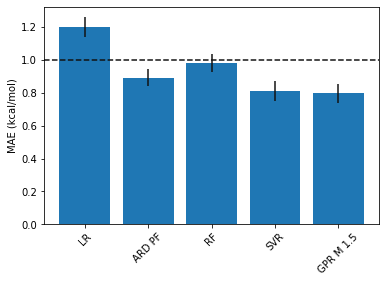

In [39]:
score_names = ["mae"]
plot_list = ["LR", "ARD PF", "RF", "SVR", "GPR M 1.5"]
labels = ["LR", "ARD PF", "RF", "SVR", "GPR M 1.5"]
plot(score_names, plot_list, test_family_results, width=1)

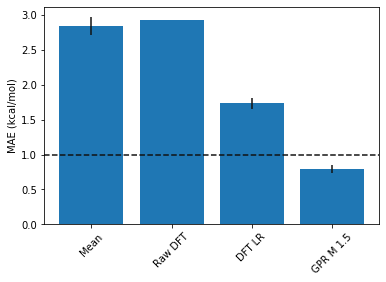

In [40]:
score_names = ["mae"]
plot_list = ["Mean", "DFT", "DFT LR", "GPR M 1.5"]
labels = ["Mean", "Raw DFT", "DFT LR", "GPR M 1.5"]
plot(score_names, plot_list, test_family_results)

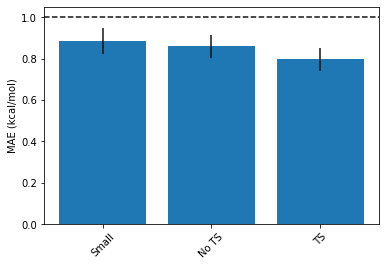

In [41]:
score_names = ["mae"]
plot_list = ["GPR M 1.5 S", "GPR M 1.5 no TS", "GPR M 1.5"]
labels = ["Small", "No TS", "TS"]
plot(score_names, plot_list, test_family_results)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

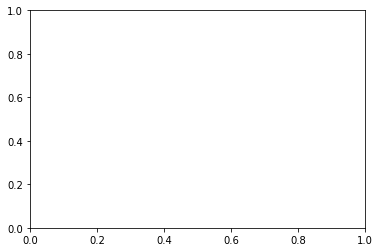

In [42]:
score_names = ["mae"]
plot_list = ["Mean", "GPR M 1.5 OHE", "GPR M 1.5 I atom", "GPR M 1.5 I seq", "GPR M 1.5 Morgan3"]
labels = ["Mean", "OHE", "ISIDA atom", "ISIDA seq", "Morgan3"]
plot(score_names, plot_list, test_family_results)

Get best overall estimator

In [43]:
best_scoring_function = scoring_functions[1]
n_top = 3

scoring_name = best_scoring_function.name
scoring_function = best_scoring_function.function
if best_scoring_function.greater_is_better:
    selection_function = lambda x: np.argsort(x)[::-1]
else:
    selection_function = np.argsort

print("Chosen scoring function:", scoring_name)

Chosen scoring function: mae


In [44]:
all_scores = np.array([est_fam.corrected_scores[scoring_name] for est_fam in est_families])
best_k = selection_function(all_scores)[:n_top]
for i in best_k:
    est_family = est_families[i]
    name = est_family.name
    score = est_family.corrected_scores[scoring_name]
    print(f"{name:15s}{score:.3f}")

GPR M 1.5      0.797
GPR M 2.5      0.807
SVR            0.810


In [45]:
best_family = est_families[best_k[0]]
best_estimator = best_family.best_estimators[scoring_name]
best_index = best_family.best_indices[scoring_name]
best_score = best_family.best_scores[scoring_name]

In [46]:
best_cv_preds = best_family.cv_preds[:, best_index].reshape(-1)

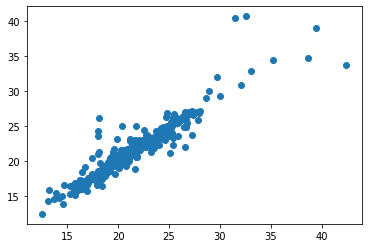

In [47]:
plt.scatter(y, best_cv_preds)

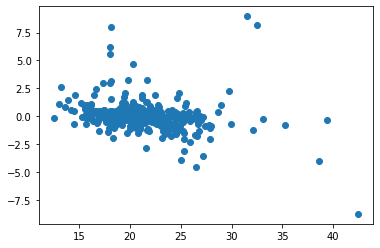

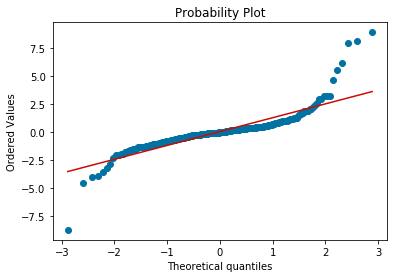

In [48]:
residuals = best_cv_preds - y
residuals.shape
plt.scatter(y, residuals)
plt.show()
_ = probplot(residuals, plot=plt)

### Estimate bias from choosing the best method

In [68]:
all_preds = []
for est_fam in est_families:
    all_preds.append(est_fam.cv_preds)
all_preds = np.hstack(all_preds)    

In [69]:
corrected_score, ci, all_scores = bbc_cv_correction(all_preds, y,
                                                scoring=best_scoring_function.name,
                                                greater_is_better=best_scoring_function.greater_is_better,
                                                return_scores=True,
                                                alpha=[0.05, 0.5],
                                                n_boot=1000)

In [70]:
bias = corrected_score - best_score

In [71]:
print(f"{'Corrected score:':20s}{corrected_score:.3f}")
print(f"{'Best score:':20s}{best_score:.3f}")
print(f"{'Bias:':20s}{bias:.3f}")
print(f"{'95% CI:':20s}" + '-'.join([f'{i:.3f}' for i in ci[0]]))
print(f"{'50% CI:':20s}" + '-'.join([f'{i:.3f}' for i in ci[1]]))

Corrected score:    0.819
Best score:         0.794
Bias:               0.025
95% CI:             0.651-0.994
50% CI:             0.759-0.879


#### Y-scrambling test

In [72]:
for scoring_function in scoring_functions:
    print(scoring_function.name)
    true_score, permutation_scores, p_value = permutation_test_score(best_estimator, X, y, cv=cv_folds, n_permutations=10, scoring=make_scorer(scoring_function.function), random_state=1)
    permutation_score_avg = np.mean(permutation_scores)
    print("True score:", true_score)
    print("Permutation score average:", permutation_score_avg)

r2
True score: 0.8634641399965901
Permutation score average: -0.05481969284833108
mae
True score: 0.7943643813939154
Permutation score average: 2.86990237792845
rmse
True score: 1.3479641651041436
Permutation score average: 3.878543847277721


#### Leave groups out tests 

Leave groups with same reaction but different solvents out

In [49]:
group_indices = np.load("train_test_data/group_indices.npy")[train]
groups, counts = np.unique(group_indices, return_counts=True)
cv_groups = groups[counts > 1]

Xfull dataset

In [50]:
scores = []
for group in cv_groups:
    est = clone(best_estimator)
    group_test = np.where(group_indices == group)[0]
    group_train = np.where(group_indices != group)[0]
    est.fit(X.iloc[group_train], y[group_train])
    preds = est.predict(X.iloc[group_test])
    score = mean_absolute_error(y[group_test], preds)
    scores.append(score)
scores = np.array(scores)

In [51]:
mae = scores.mean()
standard_error = scipy.stats.sem(scores)
print(f"MAE: {mae:.2f}")
print(f"Standar error: {standard_error:.2f}")

MAE: 1.00
Standar error: 0.23


X_bert dataset

In [53]:
scores = []
for group in cv_groups:
    est = clone(est_gpr_matern_3_2_cat)
    group_test = np.where(group_indices == group)[0]
    group_train = np.where(group_indices != group)[0]
    est.fit(X_bert_pt.iloc[group_train], y[group_train])
    preds = est.predict(X_bert_pt.iloc[group_test])
    score = mean_absolute_error(y[group_test], preds)
    scores.append(score)
scores = np.array(scores)

In [54]:
mae = scores.mean()
standard_error = scipy.stats.sem(scores)
print(f"MAE: {mae:.2f}")
print(f"Standar error: {standard_error:.2f}")

MAE: 1.11
Standar error: 0.13


Leave substrates out

In [76]:
substrate_indices = np.load("train_test_data/substrate_indices.npy")[train]
scores = cross_val_score(best_estimator, X, y, cv=LeaveOneGroupOut().split(X, y, substrate_indices), scoring=make_scorer(mean_absolute_error), n_jobs=-1)

In [77]:
mae = scores.mean()
standard_error = scipy.stats.sem(scores)
print(f"MAE: {mae:.2f}")
print(f"Standard error: {standard_error:.2f}")

MAE: 1.20
Standard error: 0.15


Leave nucleophiles out

In [78]:
nu_indices = np.load("train_test_data/nu_indices.npy")[train]
scores = cross_val_score(best_estimator, X, y, cv=LeaveOneGroupOut().split(X, y, nu_indices), scoring=make_scorer(mean_absolute_error), n_jobs=-1)

In [79]:
mae = scores.mean()
standard_error = scipy.stats.sem(scores)
print(f"MAE: {mae:.2f}")
print(f"Standard error: {standard_error:.2f}")

MAE: 0.68
Standard error: 0.08


### Fingerprint models

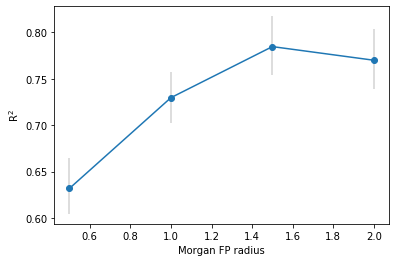

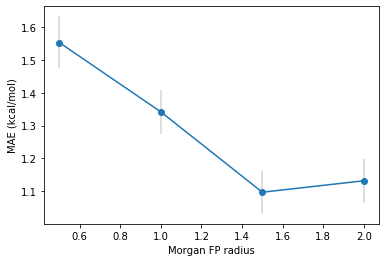

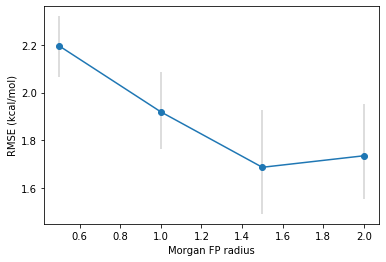

In [80]:
scores = [("r2", "R$^2$"), ("mae", "MAE (kcal/mol)"), ("rmse", "RMSE (kcal/mol)")]
lengths = np.array([1, 2, 3, 4])
for score_name, y_label in scores:
    model_name = "GPR M 1.5 Morgan{}"
    scores = [family_results[score_name][model_name.format(length)]["best_score"] for length in lengths]
    errors = np.array([family_results[score_name][model_name.format(length)]["standard_error"] for length in lengths]).T
    plt.errorbar(lengths / 2, scores, yerr=errors, ecolor="lightgrey", fmt="-o")
    plt.xlabel("Morgan FP radius")
    plt.ylabel(y_label)
    plt.show()

# Make plots for paper

Model performance

In [41]:
figsize_default = np.array(matplotlib.rc_params()["figure.figsize"])
%config InlineBackend.figure_format = "svg"

In [42]:
plot_list = ["LR", "ARD PF", "RF", "SVR", "GPR M 1.5"]
all_labels = ["LR", "ARD PF", "RF", "SVR", "GPR M 3/2"]

In [43]:
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
all_scores = plot_df["corrected_score"]
all_yerr = np.vstack(plot_df["standard_error"].values).T

In [44]:
plot_list = ["Mean", "DFT", "DFT LR", "GPR M 1.5"]
dft_labels = ["Mean", "Raw DFT", "DFT LR", "GPR M 3/2"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
dft_scores = plot_df["corrected_score"]
dft_yerr = np.vstack(plot_df["standard_error"].values).T
dft_yerr[:,1] = None

In [45]:
plot_list = ["GPR M 1.5 S", "GPR M 1.5 no TS", "GPR M 1.5"]
feature_labels = ["Small", "No TS", "Full"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
feature_scores = plot_df["corrected_score"]
feature_yerr = np.vstack(plot_df["standard_error"].values).T

In [46]:
plot_list = ["GPR M 1.5 I atom 4", "GPR M 1.5 I seq 6", "GPR M 1.5 Morgan3", "GPR M 1.5 BERT pt", "GPR M 1.5"]
structure_labels = ["ISIDA atom", "ISIDA seq", "Morgan3", "BERT", "Full"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
structure_scores = plot_df["corrected_score"]
structure_yerr = np.vstack(plot_df["standard_error"].values).T

Text(-0.15, 1.0, '(d)')

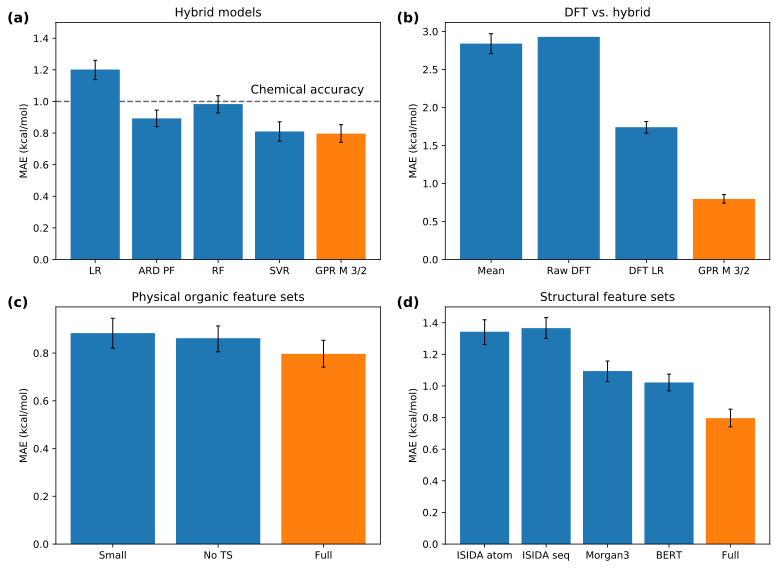

In [51]:
fix, ax = plt.subplots(2, 2, figsize=figsize_default * [2, 2])
ax[0,0].bar(all_labels, all_scores, yerr=all_yerr, ecolor="black", capsize=2, error_kw={"linewidth": 1}, color=["tab:blue"]  * 4 + ["tab:orange"])
ax[0,0].set_ylim(0, 1.5)
ax[0,0].axhline(1.0, linestyle="--", color="dimgray", label="Chemical accuracy", zorder=0)
ax[0,0].text(0.6, 0.7, "Chemical accuracy", transform=ax[0,0].transAxes, fontsize=12)
ax[0,0].set_title("Hybrid models")
ax[0,0].set_ylabel("MAE (kcal/mol)")
ax[0,1].bar(dft_labels, dft_scores, yerr=dft_yerr, ecolor="black", capsize=2, error_kw={"linewidth": 1}, color=["tab:blue"]  * 3 + ["tab:orange"])
ax[0,1].set_title("DFT vs. hybrid")
ax[0,1].set_ylabel("MAE (kcal/mol)")
ax[1,0].bar(feature_labels, feature_scores, yerr=feature_yerr, ecolor="black", capsize=2, error_kw={"linewidth": 1}, color=["tab:blue"]  * 2 + ["tab:orange"])
ax[1,0].set_title("Physical organic feature sets")
ax[1,0].set_ylabel("MAE (kcal/mol)")
ax[1,1].bar(structure_labels, structure_scores, yerr=structure_yerr, ecolor="black", capsize=2, error_kw={"linewidth": 1}, color=["tab:blue"]  * 4 + ["tab:orange"])
ax[1,1].set_ylim(0, 1.5)
ax[1,1].set_title("Structural feature sets")
ax[1,1].set_ylabel("MAE (kcal/mol)")

# Place labels
label_size = 14
label_placement = (-0.15, 1.0)
ax[0,0].text(*label_placement, "(a)", transform=ax[0,0].transAxes, fontweight="bold", fontsize=label_size)
ax[0,1].text(*label_placement, "(b)", transform=ax[0,1].transAxes, fontweight="bold", fontsize=label_size)
ax[1,0].text(*label_placement, "(c)", transform=ax[1,0].transAxes, fontweight="bold", fontsize=label_size)
ax[1,1].text(*label_placement, "(d)", transform=ax[1,1].transAxes, fontweight="bold", fontsize=label_size)

All plots

In [ ]:
plot_list = []
all_labels = [ "GPR M 3/2"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
all_scores = plot_df["corrected_score"]
all_yerr = np.vstack(plot_df["standard_error"].values).T

plot_list = [ "GPR M 1.5"]
structure_labels = [, "Full"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
structure_scores = plot_df["corrected_score"]
structure_yerr = np.vstack(plot_df["standard_error"].values).T

plot_list = ["GPR M 1.5 S",  "GPR M 1.5"]
feature_labels = ["Small", "No TS", "Full"]
plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
feature_scores = plot_df["corrected_score"]
feature_yerr = np.vstack(plot_df["standard_error"].values).T

In [65]:
plot_list = ["Mean", "DFT", "DFT LR", "LR", "ARD PF", "RF", "SVR", "GPR M 1.5 S", "GPR M 1.5 no TS", "GPR M 1.5", "GPR M 1.5 I atom 4", "GPR M 1.5 I seq 6", "GPR M 1.5 Morgan3", "GPR M 1.5 BERT pt"]
all_labels = ["Mean", "Raw DFT", "DFT LR", "LR", "ARD PF", "RF", "SVR", "GPR M 3/2 Small", "GPR M 3/2 No TS", "GPR M 3/2 Full", "GPR M 3/2 ISIDA atom", "GPR M 3/2 ISIDA seq", "GPR M 3/2 Morgan3", "GPR M 3/2 BERT"]

plot_df = pd.DataFrame(test_family_results["mae"])[plot_list]
plot_df = plot_df.T
all_scores = plot_df["corrected_score"]
all_yerr = np.vstack(plot_df["standard_error"].values).T
all_yerr[:,1] = None

Text(0, 0.5, 'MAE (kcal/mol)')

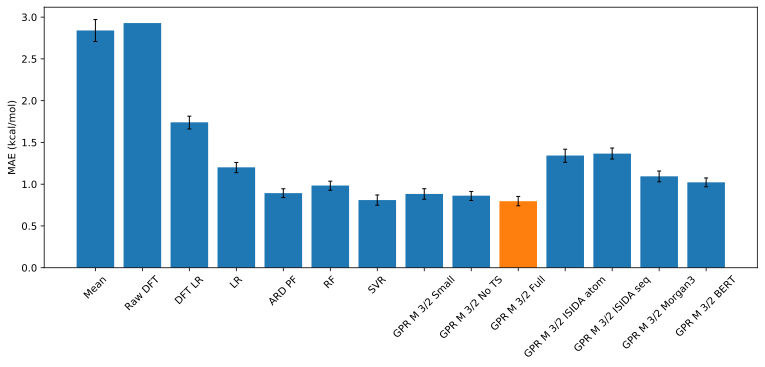

In [69]:
plt.subplots(figsize=figsize_default*[2, 1])
plt.bar(all_labels, all_scores, yerr=all_yerr, ecolor="black", capsize=2, error_kw={"linewidth": 1}, color=["tab:blue"]  * 9 + ["tab:orange"])
plt.xticks(rotation=45)
plt.ylabel("MAE (kcal/mol)")

Fingerprint length

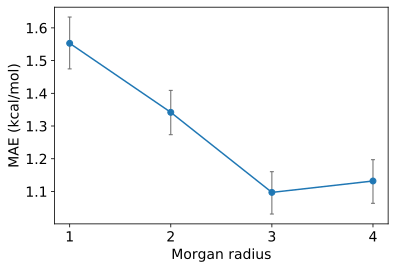

In [89]:
lengths = np.array([1, 2, 3, 4])
scores = [family_results["mae"]["GPR M 1.5 Morgan{}".format(length)]["best_score"] for length in lengths]
errors = np.array([family_results["mae"]["GPR M 1.5 Morgan{}".format(length)]["standard_error"] for length in lengths]).T
with matplotlib.style.context({'font.size': 14}):
    plt.errorbar(lengths, scores, yerr=errors, ecolor="dimgray", capsize=2, elinewidth=1, fmt="-o")
    plt.xlabel("Morgan radius")
    plt.ylabel("MAE (kcal/mol)")
    plt.xticks(lengths)
    plt.show()